# An Introduction to the AWS Fraud Detector Prediction API  
#### Supervised fraud detection  
-------
- [Introduction](#Introduction)
- [Setup](#Setup)
- [Plan](#Plan)

### Reviews 
https://github.com/aayush210789/Deception-Detection-on-Amazon-reviews-dataset



## Introduction
-------

Amazon Fraud Detector is a fully managed service that makes it easy to identify potentially fraudulent online activities such as online payment fraud and the creation of fake accounts. Fraud Detector capitalizes on the latest advances in machine learning (ML) and 20 years of fraud detection expertise from AWS and Amazon.com to automatically identify potentially fraudulent activity so you can catch more fraud faster. 

In this notebook, we'll use the Amazon Fraud Detector Predict API to apply a Dector to sample data to identify potentially fraudlent envents. After running this notebook you should be able to: 

- Apply the Detector's "predict" function, to generate a model score and rule outcomes on data  

If you would like to know more, please check out the [Fraud Detector's Documentation](https://docs.aws.amazon.com/frauddetector/). 

## Setup
------
First setup your AWS credentials so that Fraud Detector can store and access training data and supporting detector artifacts 


### Setting up AWS Credentials & Permissions

https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html

To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your 
behalf and to access resources that you own.

We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.

The following policies provide the required permission to use Amazon Fraud Detector:

- *AmazonFraudDetectorFullAccessPolicy*  
    Allows you to perform the following actions:  
        - Access all Amazon Fraud Detector resources  
        - List and describe all model endpoints in Amazon SageMaker  
        - List all IAM roles in the account  
        - List all Amazon S3 buckets  
        - Allow IAM Pass Role to pass a role to Amazon Fraud Detector  

- *AmazonS3FullAccess*  
    Allows full access to Amazon S3. This is required to upload training files to S3.  



## Plan
------

A *Detector* contains the model(s) and rule(s) detection logic for a particular type of fraud that you want to detect. We'll use the following 5 step process to plan a Fraud Detector: 

1. Detector Name  
    - You'll need the name of the detector, you can look this up in the AFD console 
    
2. Model Name   
    - You'll need the active model name and Version used by the detector  
    
3. Call Prediction API 
    - You'll need to specify the number of records to predict 

4. Score Threshold
    - the score threshold is the cut off where above the threshold you'll call the record fraud else it's legit 
    - this is used to create confusion matrix (TP,FP,TN,FN)  
    


In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# -- dask for parallelisim -- 
import dask 

# -- standard stuff -- 
import os
import sys
import time
from datetime import datetime
import json

# -- AWS stuff -- 
import boto3
import sagemaker

# -- sklearn --
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline 

## Initialize AWS Fraud Detector Client 
------

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html 


In [2]:
# -- fraud detector client --
client = boto3.client('frauddetector')


### Detector, Model, and Identifiers 
-----
<div class="alert alert-info"> 💡 <strong> Detector, Model and Versions </strong>

- DETECTOR_NAME & VERSION coresponds to the name and version of your deployed Fraud Detector  
- MODEL_NAME & VERSION coresponds to the name and version of the model deployed with your Fraud Detector   
- FRAUD_LABEL is useful if you are <b> comparing performance of your detector's </b>predictions to known frauds this is optional   
- EMAIL_ADDRESS is used as a key to identify your prediction infrences, you can look up a specific infrence in console by seraching for a specific email address. This maps to the <b>email address field</b> in your file you are predicting on. 
- S3_FILE this is the url of the S3 file you wish to apply your detector to.   

</div>

```python 
DETECTOR_NAME = "your_fraud_detector_name"
DETECTOR_VER  = '1.0'

MODEL_NAME    = "your_model_name"
MODEL_VER     = '1.0'

# -- if fraud label exists -- 
FRAUD_LABEL   = "your_target_field"

# -- use email as the identifier for predictions
EMAIL_ADDRESS = "email_address"

# -- input file of data to be scored -- 
S3_FILE       = "s3://your-bucket-name/your-file-to-predict.csv"
```

In [3]:
DETECTOR_NAME = "sample_detector_20200310"
DETECTOR_VER  = '1.0'

MODEL_NAME    = "sample_model_20200310"
MODEL_VER     = '1.0'

# -- if fraud label exists -- 
FRAUD_LABEL   = "is_fraud"

# -- use email as the identifier for predictions
EMAIL_ADDRESS = "email_address"

# -- input file of data to be scored -- 
S3_FILE       = "s3://afd-sample-bucket/detector_1/synthitic_newaccount_data_1k_test.csv"


#### Load Data to be Scored 
-----
<div class="alert alert-info"> 💡 <strong> Check the first 5 Records </strong>

- Does your data look correct? 
</div>

In [4]:
df = pd.read_csv(S3_FILE)
df.head()

,order_amt,ip_address,email_address,credit_card_bin,billing_postal,shipping_postal,event_timestamp,customer_name,billing_address,shipping_address,is_fraud
0,8036.0,192.18.59.93,synth_patrickjennings@gmail.com,42785,17740-2745,20950-6945,2019-03-31 11:21:22,Jeremy Dougherty,"4429 Ann Center\nDonnachester, GA",689 Jessica Centers Suite 969\nNorth Timothypo...,0
1,7839.0,192.88.102.55,synth_nicholas60@yahoo.com,30004,81975-4358,10975-4292,2019-06-23 02:13:27,Scott Keller,"451 Corey Hollow\nLake Vincentview, WA","6574 Wyatt Common\nLanestad, NC",0
2,3225.0,192.52.207.254,synth_chill@yahoo.com,54517,96275-0682,89722-4734,2019-04-13 23:55:51,Stacy Riggs,"2704 Laura Spurs\nEast Kathyland, NH","237 Butler Stream Suite 076\nHendersonview, WY",0
3,8109.0,198.10.49.139,synth_ericksonrandy@yahoo.com,35933,49934-1837,31347-4011,2020-01-03 18:29:06,Angela Robinson,"663 Simpson Ramp Apt. 033\nSouth Matthew, VT","189 Lynn Course\nBillyville, MD",0
4,4926.0,192.0.116.87,synth_gwade@hotmail.com,54658,88645-7360,03075-4962,2019-08-16 07:03:38,Caroline Herrera PhD,"6614 Seth Mountains Suite 667\nEast Erinland, LA","PSC 7948, Box 4183\nAPO AE",0


#### Detector Details 
-----

This simply displays details about your detector, the main thing you want to see is that your Detector's statsus is 'ACTIVE' 

In [5]:
# -- details on your detector -- 
response = client.describe_detector(
    detectorId = DETECTOR_NAME ,
)
response 

{'detectorId': 'sample_detector_20200310',
 'detectorVersionSummaries': [{'detectorVersionId': '1.0',
   'status': 'ACTIVE',
   'description': 'detects synthetic fraud events created:20200310'},
  {'detectorVersionId': '2.0',
   'status': 'DRAFT',
   'description': 'detects synthetic fraud events created:20200310'}],
 'ResponseMetadata': {'RequestId': '52a4e4a5-0522-48e2-ad1b-fe71e0d143b0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 10 Mar 2020 19:39:05 GMT',
   'x-amzn-requestid': '52a4e4a5-0522-48e2-ad1b-fe71e0d143b0',
   'content-length': '289',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Model Info
------

This section will display the score threshold table that you see in console. 

In [6]:
# -- model performance summary -- 
auc = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber=MODEL_VER,
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['auc'])

thr = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber=MODEL_VER,
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['thresholds'])

fpr = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber=MODEL_VER,
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['fpr'])

tpr = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber=MODEL_VER,
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['tpr'])

precision = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber=MODEL_VER,
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['precision'])
precision

df_model = pd.DataFrame(list(zip(thr, fpr, tpr, precision)), columns=['thr','fpr', 'tpr', 'precision'])
model_stat = df_model.round(decimals=2)               
m = model_stat.loc[model_stat.groupby(["fpr"])["thr"].idxmax()] 
def make_rule(x):
    return "\'score > " + str(x) + "\'"
    
m['score threshold'] = m['thr'].apply(lambda x: make_rule(x))

print (" --- score thresholds 1% to 10% --- ")
print(m[["fpr", "tpr", "score threshold"]].loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.1)].reset_index(drop=True))

 --- score thresholds 1% to 10% --- 
    fpr   tpr  score threshold
0  0.01  0.27  'score > 765.0'
1  0.02  0.42  'score > 605.0'
2  0.03  0.53  'score > 475.0'
3  0.04  0.61  'score > 375.0'
4  0.05  0.65  'score > 295.0'
5  0.06  0.67  'score > 245.0'
6  0.07  0.70  'score > 215.0'
7  0.08  0.75  'score > 175.0'
8  0.09  0.77  'score > 160.0'
9  0.10  0.78  'score > 145.0'


### Score Thresholds 

----
Identify a score threshold based on the false positive rate. 

- most operatoins operate at a 1% - 4% false positive ratio 


<div class="alert alert-info"> 💡 <strong> False Positive & True Positive Rates </strong>

- false positive rate - is the % of events incorrectly identified as fraud for a given score threshold 

- true positive rate - is the % of events correctly identified at a given score threshold 

- identify a score threshold that coresponds to your false positive rate, if in doubt start with the 1% FPR


</div>

In [7]:
# -- update threshold -- 
score_threshold = 605

# -- FPR based on score threshold above -- 
fpr_threshold = list(m.iloc[(m['thr']- score_threshold).abs().argsort()[:1]]['fpr'])[0]
tpr_threshold = list(m.iloc[(m['thr']- score_threshold).abs().argsort()[:1]]['tpr'])[0]

print("At the score of " + str(score_threshold) + " the model will idenitify " + str(tpr_threshold * 100) + "% of fraudulent events with a " + str(fpr_threshold*100)+"% false rate")

At the score of 605 the model will idenitify 42.0% of fraudulent events with a 2.0% false rate


### Model ROC Plot 
------
The following charts show the model Area Under the Curve at the Specified Score threshold and coresponding False Positive Rate and True Positive Rate

<Figure size 1440x720 with 0 Axes>

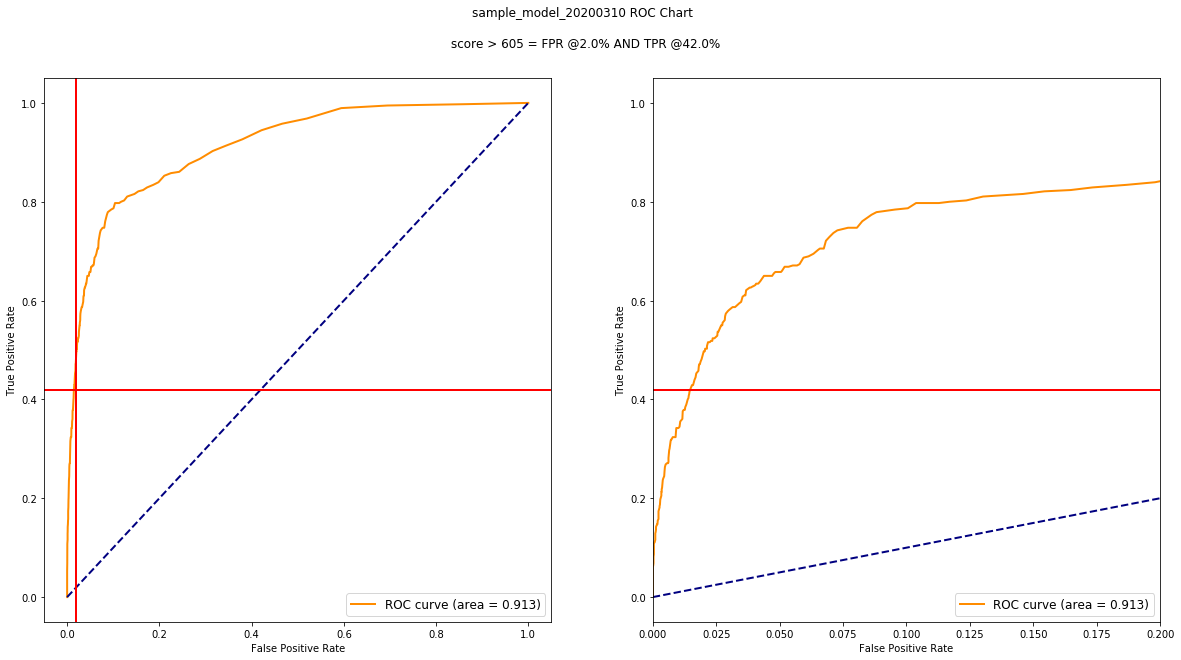

In [8]:
plt.figure(figsize=(20,10),)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

fig.suptitle( MODEL_NAME + ' ROC Chart \n\n score > ' + 
           str(score_threshold) + ' = FPR @' + 
           str(fpr_threshold*100) + '% AND TPR @' + 
           str(tpr_threshold*100) +'%') 
ax1.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')

ax1.legend(loc="lower right",fontsize=12)
ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
ax1.axvline(x = fpr_threshold ,linewidth=2, color='r')
ax1.axhline(y = tpr_threshold ,linewidth=2, color='r')


ax2.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
ax2.set_xlim([0, 0.2])

ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


ax2.legend(loc="lower right",fontsize=12)
ax2.axhline(y = tpr_threshold ,linewidth=2, color='r')
ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')


fig.show()

## Get Setup for Scoring
-----
The following function returns model variables  


<div class="alert alert-info"> 💡 <strong> Model Variables </strong>

- pass just the variables needed for the detector to score 

</div>


In [9]:
def get_model_variables(MODEL_NAME):
    """ return list of variables used by a model 
    
    """
    response = client.get_models(
    modelType='ONLINE_FRAUD_INSIGHTS',
    modelId= MODEL_NAME)
    model_variables = []

    for v in response['models'][0]['modelVariables']:
        model_variables.append(v['name'])
    return model_variables

model_variables = get_model_variables(MODEL_NAME)
print("\n -- model variables -- ")
print(model_variables)


 -- model variables -- 
['order_amt', 'ip_address', 'email_address', 'credit_card_bin', 'billing_postal', 'shipping_postal', 'event_timestamp']


## Run Predictions  
-----
The following applies the get_prediction to records   

<i> Note: this uses the Dask backend to parallelize the prediction calls. </i>



<div class="alert alert-info"> 💡 <strong>get_prediction </strong>

- Specify the number of records to score, you change the record_count to a specific number if you want to just predict on say 100 records, by default it assumes you want to apply predicitons to the whole dataset. 
- Once completed conver json to a pandas dataframe, appends any existing labels
- Analyze based on score threshold for a particular false positive rate FPR

</div>

In [10]:
df.shape[0]

1000

In [11]:
record_count = df.shape[0]

start = time.time()

@dask.delayed
def _predict(record):
    stime = time.time()
    try:
        pred  = client.get_prediction(detectorId=DETECTOR_NAME, detectorVersionId='1.0', eventId = record[EMAIL_ADDRESS], eventAttributes = record)
        etime = time.time()
        record['outcome'] = pred['outcomes'][0]
        record['status'] = pred['ResponseMetadata']['HTTPStatusCode']
        record['score']  = pred['modelScores'][0]['scores'][MODEL_NAME + '_insightscore']
        record['score_ms'] = ((etime - stime)*1000)
        return record
    except:
        pred  = client.get_prediction(detectorId=DETECTOR_NAME, detectorVersionId='1.0', eventId = record[EMAIL_ADDRESS], eventAttributes = record)
        etime = time.time()
        record['outcome'] = '-- failed --'
        record['status']  = pred['ResponseMetadata']['HTTPStatusCode']
        record['score']   =  -1 
        record['score_ms'] = ((etime - stime)*1000)
        return record

predict_data  = df[model_variables].head(record_count).astype(str).to_dict(orient='records')
predict_score = []

i=0
for record in predict_data:
    clear_output(wait=True)
    rec = dask.delayed(_predict)(record)
    predict_score.append(rec)
    i += 1
    print("current progress: ", round((i/record_count)*100,2), "%" )
    

predict_recs = dask.compute(*predict_score)

# Calculate time taken and print results
time_taken = time.time() - start
tps = len(predict_recs) / time_taken

print ('Process took %0.2f seconds' %time_taken)
print ('Scored %d records' %len(predict_recs))



current progress:  100.0 %
Process took 65.23 seconds
Scored 1000 records


### Take a look at your predictions
-----
Each record will have a score, the time (ms) it took to score it, the outcome and if a label was provided the label. 

In [12]:
predictions = pd.DataFrame.from_dict(predict_recs, orient='columns')
if FRAUD_LABEL:
    predictions[FRAUD_LABEL] = df[FRAUD_LABEL].head(record_count)
    all_variables = ['score', 'score_ms', 'outcome', FRAUD_LABEL] + model_variables
else:
    all_variables = ['score', 'score_ms', 'outcome'] + model_variables

predictions[all_variables].head()

,score,score_ms,outcome,is_fraud,order_amt,ip_address,email_address,credit_card_bin,billing_postal,shipping_postal,event_timestamp
0,50.0,113.531113,approve,0,8036.0,192.18.59.93,synth_patrickjennings@gmail.com,42785,17740-2745,20950-6945,2019-03-31 11:21:22
1,83.0,113.424301,approve,0,7839.0,192.88.102.55,synth_nicholas60@yahoo.com,30004,81975-4358,10975-4292,2019-06-23 02:13:27
2,66.0,120.327950,approve,0,3225.0,192.52.207.254,synth_chill@yahoo.com,54517,96275-0682,89722-4734,2019-04-13 23:55:51
3,77.0,126.074076,approve,0,8109.0,198.10.49.139,synth_ericksonrandy@yahoo.com,35933,49934-1837,31347-4011,2020-01-03 18:29:06
4,18.0,155.073881,approve,0,4926.0,192.0.116.87,synth_gwade@hotmail.com,54658,88645-7360,03075-4962,2019-08-16 07:03:38


```python
from sklearn.metrics import accuracy_score
predictions.loc[predictions['score'] >= score_threshold, 'y_pred'] = 1
predictions.loc[predictions['score'] < score_threshold, 'y_pred'] = 0
accuracy_score(predictions[FRAUD_LABEL], predictions['y_pred'])
```

### Optionally Write Predictions to File

<div class="alert alert-info"> <strong> Write Predictions </strong>

- You can write your prediction dataset to a CSV to manually review predictions
- Simply add a cell below and copy the code below

</div>



```python

# -- optionally write predictions to a CSV file -- 
predictions.to_csv(MODEL_NAME + ".csv", index=False)
# -- or to a XLS file 
predictions.to_excel(MODEL_NAME + ".xlsx", index=False)

```

## EVALUATION
------
The following section requires FRAUD_LABEL to be set to a Column value in the prediction dataset 

#### Score Distribution
-----


<div class="alert alert-info"> 💡 <strong> Separationg </strong>

- typically we recomend 1 - 4% false positive rate (FPR) but this is totally business dependant 
- the table below will help you identify a score threshold to evaluate your model with. 

</div>

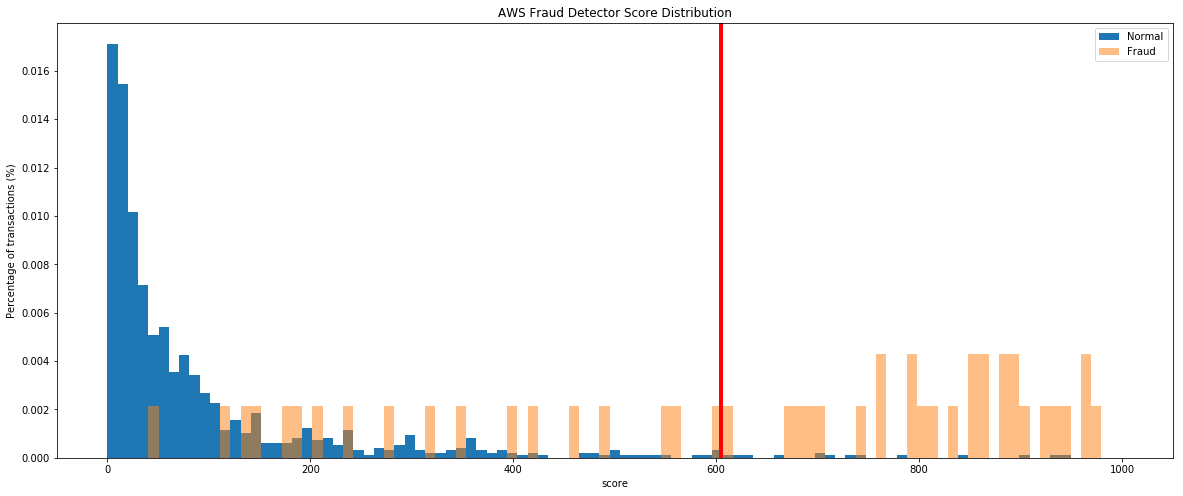

In [13]:
if FRAUD_LABEL:
    # -- assign predictions based on threshold --
    predictions.loc[predictions['score'].astype(float) > score_threshold, "predicted_fraud" ] = 1
    predictions.loc[predictions['score'].astype(float) <= score_threshold, "predicted_fraud" ] = 0


    fraud = predictions.loc[predictions[FRAUD_LABEL] == 1 ]
    legit = predictions.loc[predictions[FRAUD_LABEL] == 0 ]

    bins = np.linspace(0, 1000, 100)
    plt.figure(figsize=(20,8))
    plt.hist(legit['score'].astype(float) , bins, alpha=1, density=True, label='Normal')
    plt.hist(fraud['score'].astype(float) , bins, alpha=0.5, density=True, label='Fraud')
    plt.legend(loc='upper right')
    plt.title("AWS Fraud Detector Score Distribution")
    plt.xlabel("score")
    plt.ylabel("Percentage of transactions (%)");
    plt.axvline(x = score_threshold ,linewidth=4, color='r')
    plt.show()

#### AWS Fraud Detector Prediction Classification 

-----

<div class="alert alert-info"> 💡 <strong> TP/TN/FP/FN </strong>

- True Positive (TP) - correctly identified fraud events  
- True Negative (TN) - correctly identified legitimate events  
- False Positive (FP) - legitmate events incorrectly identified as fraud   
- False Negative (FP) - fraudulent events incorrectly identified as legimate  


</div>

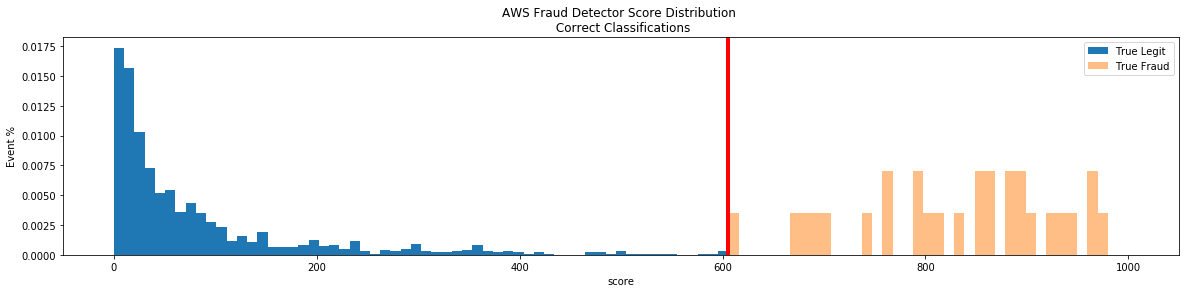

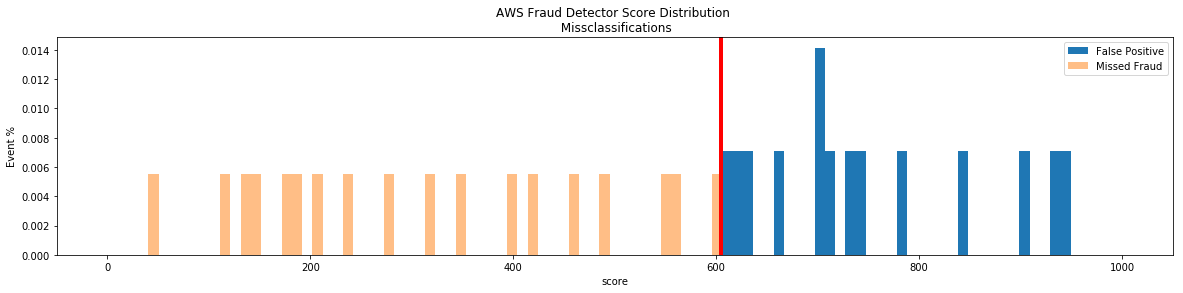

In [14]:
if FRAUD_LABEL:
    tp = predictions.loc[(predictions[FRAUD_LABEL] == 1) & (predictions['predicted_fraud'].astype(float) == 1)]
    tn = predictions.loc[(predictions[FRAUD_LABEL] == 0) & (predictions['predicted_fraud'].astype(float) == 0)]
    fp = predictions.loc[(predictions[FRAUD_LABEL] == 0) & (predictions['predicted_fraud'].astype(float) == 1)]
    fn = predictions.loc[(predictions[FRAUD_LABEL] == 1) & (predictions['predicted_fraud'].astype(float) == 0)]

    bins = np.linspace(0, 1000, 100)
    plt.figure(figsize=(20,4))
    plt.hist(tn['score'].astype(float), bins, alpha=1, density=True, label='True Legit')
    plt.hist(tp['score'].astype(float), bins, alpha=0.5, density=True, label='True Fraud')


    plt.legend(loc='upper right')
    plt.title("AWS Fraud Detector Score Distribution \n Correct Classifications")
    plt.xlabel("score")
    plt.ylabel("Event %");
    plt.axvline(x = score_threshold ,linewidth=4, color='r')
    plt.show()

    plt.figure(figsize=(20,4))
    plt.hist(fp['score'].astype(float), bins, alpha=1, density=True, label='False Positive')
    plt.hist(fn['score'].astype(float), bins, alpha=0.5, density=True, label='Missed Fraud')
    plt.legend(loc='upper right')
    plt.title("AWS Fraud Detector Score Distribution \n Missclassifications")

    plt.xlabel("score")
    plt.ylabel("Event %");
    plt.axvline(x = score_threshold ,linewidth=4, color='r')
    plt.show()

###  Confusion Matrix 
----
the following sports a typical confusion matrix of actual vs. predicted fraud / not fraud, assuming the fraud label exists

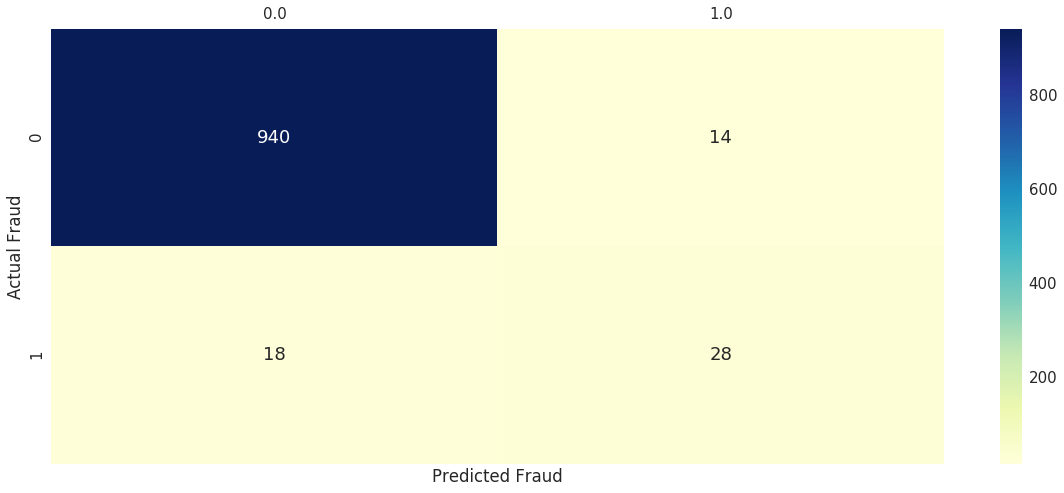

In [15]:
if FRAUD_LABEL:
    confusion_matrix = pd.crosstab(predictions[FRAUD_LABEL], predictions['predicted_fraud'], rownames=['Actual'], colnames=['Predicted'],)
    plt.figure(figsize=(20,8))
    sns.set(font_scale=1.5)
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='g',cmap="YlGnBu")
    plt.ylabel('Actual Fraud')
    plt.xlabel('Predicted Fraud')
    ax.xaxis.set_ticks_position('top')